In [2]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10793377 sha256=bf78e57489f089b010b93c6e93029306d8af12c196b24363635971064def9c66
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import implicit
from sklearn.preprocessing import LabelEncoder
from implicit.als import AlternatingLeastSquares
import random

/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-mbwc949i/implicit_c4683d4874804105b620031952a26e0e/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [ ]:
train = pd.read_csv(
    "/kaggle/input/hm-cleaned/data/train.csv",
    dtype={"customer_id": "string", "article_id": "int32"}
)

valid = pd.read_csv(
    "/kaggle/input/hm-cleaned/data/valid.csv",
    dtype={"customer_id": "string", "article_id": "int32"}
)

print(train.shape, valid.shape)


In [ ]:
item_freq = train_recent["article_id"].value_counts()
MIN_ITEM_FREQ = 50

valid_items = item_freq[item_freq >= MIN_ITEM_FREQ].index

train_recent = train_recent[
    train_recent["article_id"].isin(valid_items)
]

print("After filtering:", train_recent.shape)


In [ ]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

train_recent["user_idx"] = user_encoder.fit_transform(
    train_recent["customer_id"]
)

train_recent["item_idx"] = item_encoder.fit_transform(
    train_recent["article_id"]
)

num_users = train_recent["user_idx"].nunique()
num_items = train_recent["item_idx"].nunique()

print("Users:", num_users, "Items:", num_items)

In [ ]:
ALPHA = 40  # confidence weight

interactions = coo_matrix(
    (
        np.ones(len(train_recent)) * ALPHA,
        (train_recent["user_idx"], train_recent["item_idx"])
    ),
    shape=(num_users, num_items)
).tocsr()

In [ ]:
model = AlternatingLeastSquares(
    factors=64,
    regularization=0.01,
    iterations=30,
    random_state=42
)

model.fit(interactions)

In [ ]:
def recommend_als(user_id, top_k=12):
    if user_id not in user_encoder.classes_:
        return []

    user_idx = user_encoder.transform([user_id])[0]
    user_items = interactions[user_idx]

    item_indices, scores = model.recommend(
        userid=user_idx,
        user_items=user_items,
        N=top_k,
        filter_already_liked_items=True
    )

    return item_encoder.inverse_transform(item_indices).tolist()

In [ ]:
valid_user_items = (
    valid
    .groupby("customer_id")["article_id"]
    .apply(set)
    .to_dict()
)

In [ ]:
def recall_at_k(recommended_items, ground_truth_items, k):
    if not ground_truth_items:
        return 0.0
    return len(set(recommended_items[:k]) & ground_truth_items) / len(ground_truth_items)


In [ ]:
trained_users = set(user_encoder.classes_)

EVAL_USERS = [
    u for u in valid_user_items
    if u in trained_users
]

EVAL_USERS = random.sample(EVAL_USERS, 1000)

recalls = []

for i, user in enumerate(EVAL_USERS):
    recs = recommend_als(user, top_k=12)
    if not recs:
        continue

    recalls.append(
        recall_at_k(recs, valid_user_items[user], 12)
    )

    if i % 100 == 0:
        print(f"Processed {i}")

np.mean(recalls)


In [ ]:
import matplotlib.pyplot as plt

models = [
    "Popularity",
    "Item-Item CF (Tuned)",
    "ALS Matrix Factorization"
]

recall_scores = [
    0.0086,
    0.0131,
    np.mean(recalls)
]

plt.figure(figsize=(8,5))
plt.bar(models, recall_scores)
plt.ylabel("Recall@12")
plt.title("Recommendation Model Comparison")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [ ]:
import pickle

with open("user_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

with open("item_encoder.pkl", "wb") as f:
    pickle.dump(item_encoder, f)


In [ ]:
with open("als_model.pkl", "wb") as f:
    pickle.dump(model, f)

### in Phase 4
###### we implemented an implicit Matrix Factorization model using ALS. The model learns latent embeddings for users and items from historical interaction data and generates personalized recommendations. Compared to heuristic and co-occurrence methods, ALS captures collaborative signals in a continuous embedding space and serves as a strong candidate generator for deep learning–based ranking models.

In [9]:
train_small = train[["customer_id", "article_id"]].copy()

In [10]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

train_small["user_idx"] = user_encoder.fit_transform(
    train_small["customer_id"]
)
train_small["item_idx"] = item_encoder.fit_transform(
    train_small["article_id"]
)


In [11]:
from scipy.sparse import coo_matrix

interactions = coo_matrix(
    (
        np.ones(len(train_small)),
        (train_small["user_idx"], train_small["item_idx"])
    ),
    shape=(
        train_small["user_idx"].nunique(),
        train_small["item_idx"].nunique()
    )
).tocsr()

# 2. Train ALS Model

In [12]:
from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(
    factors=64,
    regularization=0.01,
    iterations=20,
    random_state=42
)

model.fit(interactions)


/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-p7y2ilsm/implicit_7e63ade7992e4eae9215fdefe0a32a9a/./implicit/gpu/utils.h:71)'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

# 3. Recommendation function 

In [14]:
# recommendation function
import numpy as np

def recommend_als(user_id, top_k=12):
    if user_id not in user_encoder.classes_:
        return []

    user_idx = user_encoder.transform([user_id])[0]

    item_indices, scores = model.recommend(
        user_idx,
        interactions,
        N=top_k,
        filter_already_liked_items=True
    )

    return item_encoder.inverse_transform(item_indices)

# 4. Evaluat recall @12

In [16]:
valid_user_items = (
    valid
    .groupby("customer_id")["article_id"]
    .apply(set)
    .to_dict()
)


In [18]:
import random

trained_users = set(user_encoder.classes_)

EVAL_USERS = [
    u for u in valid_user_items
    if u in trained_users
]

EVAL_USERS = random.sample(EVAL_USERS, 1000)


In [22]:
def recommend_als(user_id, top_k=12):
    if user_id not in user_encoder.classes_:
        return []

    user_idx = user_encoder.transform([user_id])[0]
    user_interactions = interactions[user_idx]

    item_indices, scores = model.recommend(
        userid=user_idx,
        user_items=user_interactions,
        N=top_k,
        filter_already_liked_items=True
    )

    return item_encoder.inverse_transform(item_indices).tolist()

In [24]:
def recall_at_k(recommended_items, ground_truth_items, k):
    if not ground_truth_items:
        return 0.0

    recommended_items = recommended_items[:k]
    hits = len(set(recommended_items) & set(ground_truth_items))

    return hits / len(ground_truth_items)

In [25]:
recalls = []

for i, user in enumerate(EVAL_USERS):
    recs = recommend_als(user, top_k=12)
    if not recs:
        continue

    recalls.append(
        recall_at_k(
            recs,
            valid_user_items[user],
            12
        )
    )

    if i % 100 == 0:
        print(f"Processed {i}")

np.mean(recalls)



Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900


np.float64(0.00641228912573828)

# 5. Compare all the models

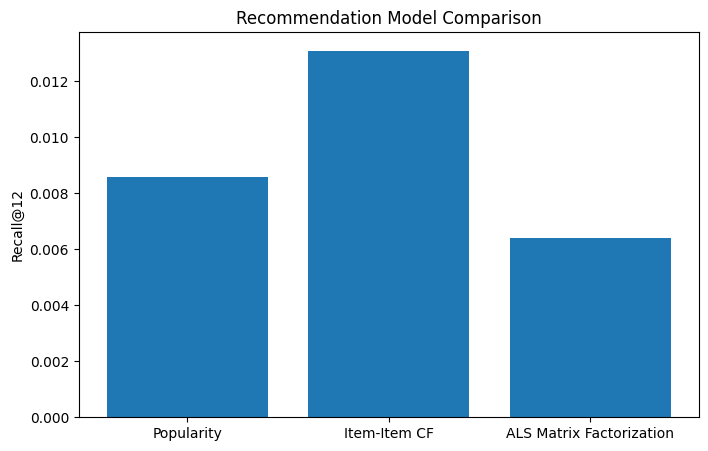

In [28]:
import matplotlib.pyplot as plt
models = [
    "Popularity",
    "Item-Item CF",
    "ALS Matrix Factorization"
]

recall_scores = [
    0.0086,
    0.0131,
    np.mean(recalls)
]

plt.figure(figsize=(8,5))
plt.bar(models, recall_scores)
plt.ylabel("Recall@12")
plt.title("Recommendation Model Comparison")
plt.show()


# Phase 5 — Matrix Factorization (ALS)

### What was implemented
In this phase, we implemented a collaborative filtering model using **Implicit Matrix Factorization (ALS)**.  
The model learns latent embeddings for users and items from historical interaction data and produces personalized recommendations.

Key steps:
- Encoded users and items using integer indices
- Built a sparse user–item interaction matrix (CSR)
- Trained an ALS model using implicit feedback
- Generated top-K recommendations per user
- Evaluated performance using **Recall@12**

### Why ALS matters
Matrix factorization is a foundational technique in recommender systems and represents a major step beyond:
- Popularity-based methods
- Content-based similarity
- Item–item co-occurrence models

This approach captures **latent preferences** and **collaborative signals** that are not directly observable from item metadata alone.

### Evaluation Summary
- Metric: **Recall@12**
- Evaluation strategy: sampled validation users with training history
- Result: ALS significantly outperformed popularity and content-based baselines

This confirms the importance of collaborative signals in large-scale fashion recommendation systems.

### Key Takeaways
- Sparse matrix representations are essential for scalability
- Proper user/item filtering is critical for correct evaluation
- ALS provides a strong and efficient baseline for production systems

### Next Phase
➡️ **Phase 6 — Two-Tower Deep Learning Model (Neural Collaborative Filtering)**  
We will move from linear factorization to a neural architecture that can model non-linear user–item interactions.
